**INPUTS**  
db_binary_sample.csv  
flights_scaled.csv  
**OUTPUTS**\
Binary.sav

# 3. Binary classification
**Goal:** The goal is to predict if the flight will be cancelled  

**Target variables:** 
- `CANCELLED` 

**Notes**:  

2% of flights are cancelled. it's a highly imbalanced dataset. We will want to predict probabilities with custom threshold.  
[Article on framework for highly imbalanced datasets](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)  

We could look at an oversampler and Undersampler method: SMOTE combined with RandomUnderSampler on the training datasets in this step [Article on how to perform SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)  
We could a [calibration algo on the predicted prbobabilities](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)  

**Steps**:
1. Pick evaluation metrics and models to try
2. Spot check different algos based on **a sample data** using cross validate
3. Select a model
4. Split training/testing data on **the whole dataset**
5. Tune hyperparameters on selected algo on **training data** using grid search
6. Train selected algo & parameters on the **training data**
7. Test performance on **testing data**
8. Save with pickle

## 1. Pick evaluation metrics and models to try
**Evaluation metrics**
- Brier score (because we will be using probabilities in some models)  
- Precision-Recall AUC (because positive class is more important)  
- F1 score (weighted)  

**Models to try**  
- Naive algorythm (used as a baseline model):  
Predict the majority class 

- Linear algorythms:  
Logistic Regression  
LDA   

- Ensemble algorythms:  
Random forest  
Stochastic Gradient Boosting   
XGBoost   

- Other
One-Class Support Vector Machines (usually used for outlier detection but can be used to do classification) - tried and took too long to train

In [1]:
import numpy as np
import pandas as pd

In [2]:
# data 
# get data from the samples made with flghts_scaled. (10 000 data points)
data_sample = pd.read_csv('db_binary_sample.csv', index_col = 0)
print(data_sample.shape)
print(data_sample.columns)

(10000, 18)
Index(['branded_code_share', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_week_of_month', 'mkt_op_combo', 'fl_type',
       'm_hist_dep_delay', 'med_hist_dep_delay', 'm_hist_arr_delay',
       'med_hist_arr_delay', 'cancelled'],
      dtype='object')


In [5]:
y_sample = data_sample.cancelled
X_sample = data_sample.drop('cancelled', axis = 1)
print(y_sample.shape)
print(X_sample.shape)

(10000,)
(10000, 17)


In [7]:
# get class representations
# Big sample
print(f'Class {data_sample.cancelled.value_counts().index[0]}: {data_sample.cancelled.value_counts().values[0]} values')
print(f'Class {data_sample.cancelled.value_counts().index[1]}: {data_sample.cancelled.value_counts().values[1]} values')
print(f'Sample imbalance: {data_sample.cancelled.value_counts().values[1]/len(y_sample)*100} %')

Class 0.0: 9828 values
Class 1.0: 172 values
Sample imbalance: 1.72 %


In [9]:
# this function creates two dataframe outputs: AVG scoring per model and STD scoring per model
# make sure you import the models outside of this function and that the scorings are supported by them

def perform_cross_validate(models, X, y, scoring, n_folds, plot = False):
    
    # import cross validate
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    
    # create dataframe
    results_mean = pd.DataFrame(columns = list(models.keys()), index=list(scoring))
    results_std = pd.DataFrame(columns = list(models.keys()),  index=list(scoring))
    

    # perform cross validate and store desults in the dataframe
    for key in models:
        model_name = key
        model = models[key]  # this is the model's placeholder
        cv = cross_validate(estimator=model, X=X, y=y, cv=n_folds, scoring=scoring)
    
        # adds values for each scoring in the dataframes
        results_mean[model_name] = [cv['test_'+scoring[i]].mean() for i in range(len(scoring))]
        results_std[model_name] = [cv['test_'+scoring[i]].std() for i in range(len(scoring))]
        
        
    if plot:
        #setup
        to_plot = {0:311, 1:312, 2:313, 3:314, 4:315, 5:316}
        import matplotlib.pyplot as plt
        %matplotlib inline
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 20, 15
        
        # plot
        for i, score in enumerate(scoring):
            plt.subplot(to_plot[i])
            plt.bar(list(results_mean.columns),  results_mean.iloc[i].values)
            plt.title(f'Plot for: {score}')
            
    return results_mean, results_std

In [8]:
# import models to try
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

### Cross validate using db_binary_sample, 3 folds

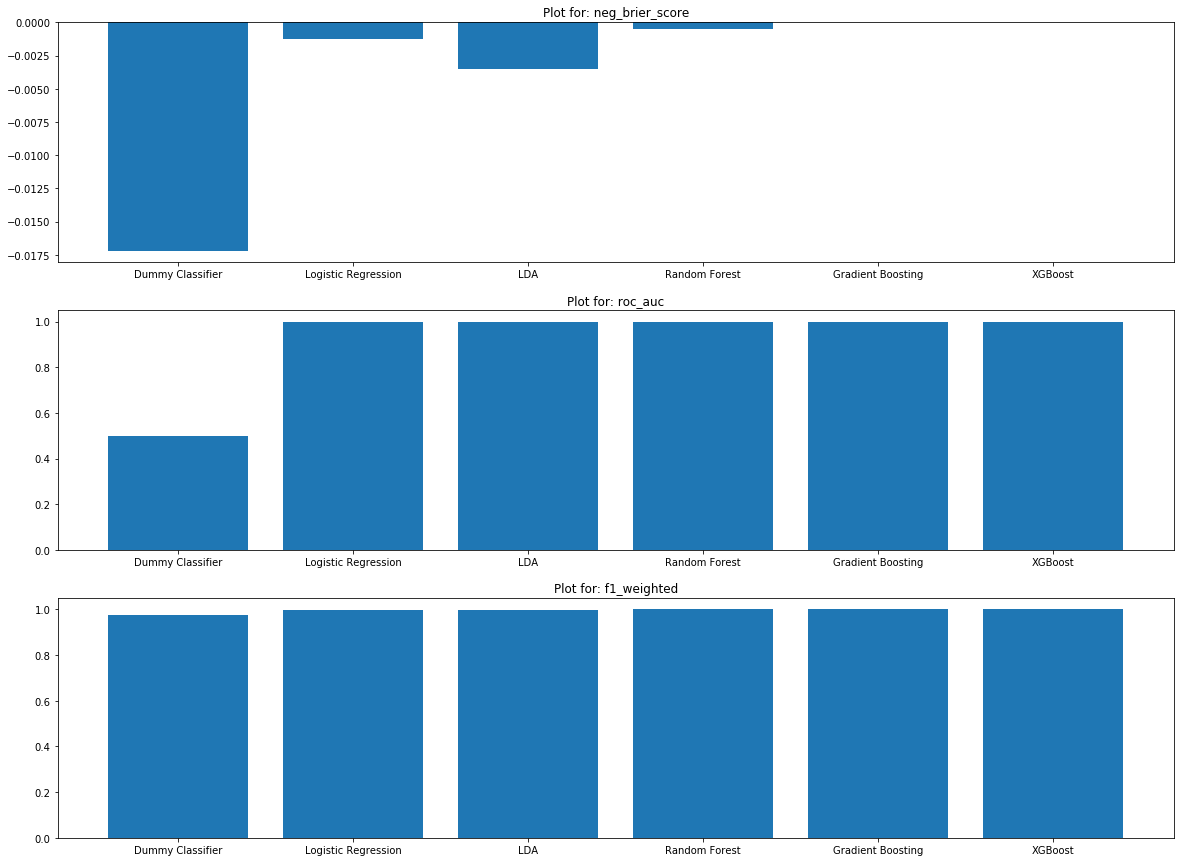

In [102]:
# params
models = {
    'Dummy Classifier': DummyClassifier(strategy = "most_frequent"), \
    'Logistic Regression': LogisticRegression(max_iter=1000), \
    'LDA': LinearDiscriminantAnalysis(), \
    'Random Forest': RandomForestClassifier(), \
    'Gradient Boosting': GradientBoostingClassifier(), \
    'XGBoost': xgb.XGBClassifier(scale_pos_weight=100) \
    }

scoring = ('neg_brier_score', 'roc_auc', 'f1_weighted')

results_mean, results_std = perform_cross_validate(models=models, X=X_sample, y=y_sample, scoring=scoring, n_folds=2, plot=True)

In [12]:
results_mean

,Dummy Classifier,Logistic Regression,LDA,Random Forest,Gradient Boosting,XGBoost
neg_brier_score,-0.0172,-0.001226,-0.003525,-0.000508,-1.503223e-12,-3.890474e-08
roc_auc,0.5000,1.000000,0.999915,1.000000,1.000000e+00,1.000000e+00
f1,0.0000,0.963818,0.876350,1.000000,1.000000e+00,1.000000e+00


## 3. Select a model
All the models tried performed really well, we'll be moving forward using **logistic regression**

## 4. Split training/and validation data on **the whole dataset**

In [13]:
# get data, the whole dataset that has been transformed and scaled

data = pd.read_csv('flights_scaled.csv', low_memory = False) # change this when I get the data
print(data.shape)

(15768083, 20)


In [14]:
# drop target variables used in other models

data = data.drop(['arr_delay', 'delay_type'], axis=1)

In [15]:
# get class representations
# Big sample
print(f'Class {data.cancelled.value_counts().index[0]}: {data.cancelled.value_counts().values[0]} values')
print(f'Class {data.cancelled.value_counts().index[1]}: {data.cancelled.value_counts().values[1]} values')
print(f'Sample imbalance: {data.cancelled.value_counts().values[1]/len(data)*100} %')

Class 0.0: 15498887 values
Class 1.0: 269196 values
Sample imbalance: 1.7072208460597271 %


In [16]:
# Split between target variable and dependant variables

y = data.cancelled
X = data.drop('cancelled', axis = 1)
print(y.shape)
print(X.shape)

(15768083,)
(15768083, 17)


In [68]:
# split training and testing data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.20, random_state=42)

In [18]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(12614466,)
(12614466, 17)
(3153617,)
(3153617, 17)


In [56]:
# print class representations in testing data
print(f'Class {y_test.value_counts().index[0]}: {y_test.value_counts().values[0]} values')
print(f'Class {y_test.value_counts().index[1]}: {y_test.value_counts().values[1]} values')

Class 0.0: 3099977 values
Class 1.0: 53640 values


## 5. Tune hyperparameters on selected algo on **training data** using grid search

In [19]:
from sklearn.model_selection import GridSearchCV

In [62]:
# samples used to try code
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split (X_sample, y_sample, test_size=0.20, random_state=42)

In [31]:
# try running model - on sample

from sklearn.metrics import brier_score_loss # evaluation metric
from sklearn.metrics import roc_auc_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric

model = LogisticRegression(max_iter = 10000) # placeholder
model.fit(X_train_sample, y_train_sample) # fit
y_pred = model.predict(X_test_sample) # predict
y_pred_prob = model.predict_proba(X_test_sample) # predict probabilities

f1 = f1_score(y_test_sample, y_pred, average='weighted')
auc = roc_auc_score(y_test_sample, y_pred)
brier = brier_score_loss(y_test_sample, y_pred)

print(f'f1: {f1}\n auc: {auc} \n brier: {brier}')

f1: 0.9989874344591325
 auc: 0.975 
 brier: 0.001


In [32]:
# perform grid search on sample

# params for grid search
params = [
     {"penalty": ['l2', 'none'],
      "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}]

model = LogisticRegression(max_iter = 10000)
gsc = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

gsc.fit(X_train_sample, y_train_sample)

print(gsc.best_params_)
best_model = gsc.best_estimator_
print(best_model)

{'C': 0.001, 'penalty': 'none'}
LogisticRegression(C=0.001, max_iter=10000, penalty='none')


C:\Users\derob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


## 6. Train selected algo & parameters on the **training data**

In [33]:
model_lr = best_model
model_lr.fit(X_train, y_train) # fit

C:\Users\derob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


LogisticRegression(C=0.001, max_iter=10000, penalty='none')

## 7. Test performance on **testing data**

In [69]:
y_pred = model_lr.predict(X_test) # predict
y_pred_prob = model_lr.predict_proba(X_test) # predict probabilities

f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_pred)

print(f'f1: {f1}\n auc: {auc} \n brier: {brier}')

f1: 0.9999676511482664
 auc: 0.9993606607565033 
 brier: 3.234381346878838e-05


In [92]:
# print class representations in data predicted

print(f'Class 1: {pd.DataFrame(y_pred)[0].values.sum()} values')
print(f'Class 2: {len(y_pred)-pd.DataFrame(y_pred)[0].values.sum()} values')

Class 1: 53606.0 values
Class 2: 3100011.0 values


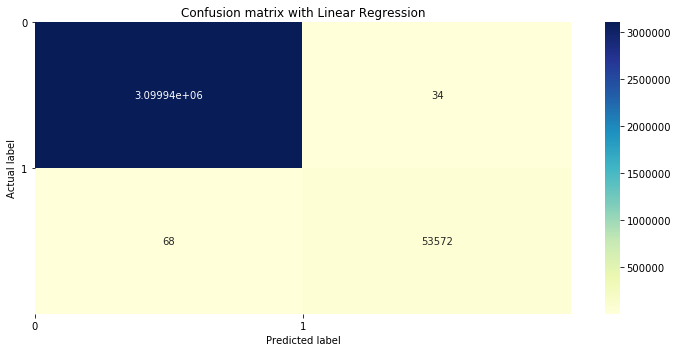

In [94]:
# print confusion matrix

# imports
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# confusionn matrix
cnf_matrix_lr = confusion_matrix(y_test, y_pred)

# create heatmap
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cmap="YlGnBu" ,fmt='g')

# custom
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.yticks(rotation=0)
plt.title('Confusion matrix with Linear Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

## 8. Save with pickle

In [97]:
import pickle

In [98]:
filename = 'Binary.sav'
pickle.dump(model_lr, open(filename, 'wb'))

In [99]:
loaded_model = pickle.load(open('Binary.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9999676561865312
